# Testing DEMV on _Law School Admissions_ (LAW) dataset

- Unprivileged group: `gender=1 && race=1`
- sex: 1 female, 0 male
- race: 0 white, 1 non white

In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
#from sklearnex import patch_sklearn
#patch_sklearn()

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


In [2]:
data = pd.read_csv('data2/bar_pass_prediction.csv', index_col='Unnamed: 0')
col_to_drop = ['ID', 'decile1b', 'decile3', 'decile1', 'cluster', 'bar1', 'bar2',
               'sex', 'male', 'race1', 'race2', 'other', 'asian', 'black', 'hisp', 'bar', 'index6040', 'indxgrp', 'indxgrp2', 'dnn_bar_pass_prediction', 'grad', 'bar1_yr', 'bar2_yr', 'ugpa']
data.drop(col_to_drop, axis=1, inplace=True)
data.loc[data['Dropout'] == 'NO', 'Dropout'] = 0
data.loc[data['Dropout'] == 'YES', 'Dropout'] = 1
data.dropna(inplace=True)
data.loc[data['gender']=='female', 'gender'] = 1
data.loc[data['gender'] == 'male', 'gender'] = 0
data.loc[data['race']==7.0, 'race'] = 0
data.loc[data['race'] != 0, 'race'] = 1
data['gpa'] = pd.qcut(data['gpa'], 3, labels=['a','b','c'])
enc = LabelEncoder()
data['gpa'] = enc.fit_transform(data['gpa'].values)
data


,race,lsat,zfygpa,DOB_yr,zgpa,fulltime,fam_inc,age,gender,parttime,Dropout,pass_bar,tier,gpa
0,0.0,44.0,1.33,69.0,1.88,1.0,5.0,-62.0,1,0.0,0,1.0,4.0,2
1,0.0,29.0,-0.11,69.0,-0.57,1.0,4.0,-62.0,1,0.0,0,1.0,2.0,2
2,0.0,36.0,-0.64,65.0,-1.12,1.0,1.0,-58.0,0,0.0,0,1.0,3.0,2
3,0.0,39.0,0.34,58.0,-0.49,1.0,4.0,-51.0,0,0.0,0,1.0,3.0,2
4,0.0,48.0,1.02,68.0,0.76,1.0,4.0,-61.0,0,0.0,0,1.0,5.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22402,1.0,26.5,-0.58,64.0,-1.49,1.0,2.0,-62.0,0,0.0,0,0.0,1.0,0
22403,1.0,19.7,-0.64,64.0,-1.36,1.0,3.0,-57.0,0,0.0,0,0.0,1.0,0
22404,1.0,36.0,0.41,66.0,0.80,2.0,3.0,-59.0,0,1.0,0,1.0,3.0,0
22405,0.0,44.0,1.88,58.0,1.42,2.0,3.0,-51.0,0,1.0,0,1.0,3.0,0


In [3]:
protected_group = {'race': 1, 'gender': 1}
label = 'gpa'
sensitive_features=['race', 'gender']
positive_label = 2

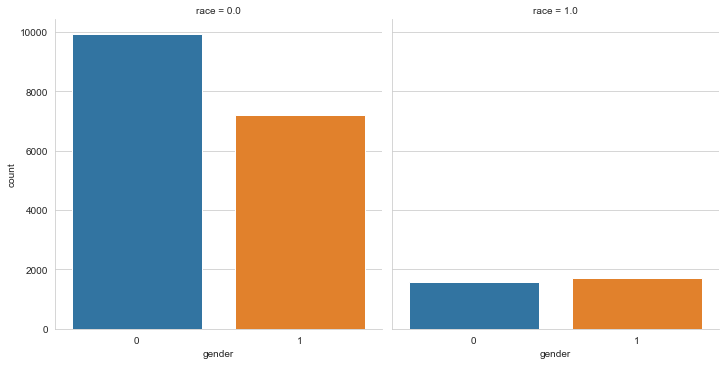

In [4]:
sns.catplot(data=data, x='gender', col='race', kind='count')
plt.show()

## Bias Metrics

### Logistic regression

In [5]:
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "classifier",
            LogisticRegression(),
        ),
    ]
)

In [6]:
model, lr_metrics,pred = cross_val2(pipeline, data, label, protected_group, sensitive_features=sensitive_features, positive_label=positive_label)
print_metrics(lr_metrics)

Statistical parity:  -0.2  +-  0.026
Disparate impact:  0.502  +-  0.068
Zero one loss:  0.164  +-  0.029
F1 score:  0.449  +-  0.011
Accuracy score:  0.521  +-  0.01


## DEMV Metrics

In [7]:
demv = DEMV(round_level=1)
demv_data = data.copy()

### Logistic regression

In [8]:
model, lr_demv = cross_val(deepcopy(pipeline), demv_data, label, protected_group, sensitive_features=sensitive_features, debiaser=demv, positive_label=2)
print_metrics(lr_demv)

Statistical parity:  -0.035  +-  0.036
Disparate impact:  0.885  +-  0.075
Zero one loss:  0.159  +-  0.021
F1 score:  0.429  +-  0.011
Accuracy score:  0.512  +-  0.011


## DEMV Evaluation

In [9]:
demv.get_iters()

618

In [10]:
metrics = eval_demv(200, demv.get_iters(), data.copy(), pipeline, label, protected_group, sensitive_features, positive_label=2)

##  Blackbox Postprocessing

In [11]:
sensitive_features = ['combined']
unpriv_group = {'combined': 1}

In [12]:
data.loc[:,"combined"] = 0
data.loc[(data['gender'] == 1) & (data["race"] == 1),"combined"] = 1

In [13]:
#Now pred has the actual values on column "y_true" and predicted values on column "contr_use"

pred.loc[:,"combined"] = 0
pred.loc[(pred['gender'] == 1) & (pred["race"] == 1),"combined"] = 1

y_pred = pred[label].values
y_true = pred['y_true'].values

In [14]:
import tools
stats = tools.clf_metrics(y_true, y_pred)
stats

,tp,fp,tn,fn,sens,spec,ppv,npv,j,f1,mcc,brier,auc,ap,true_prev,pred_prev,prev_diff,rel_prev_diff
0,3999.0,3617.0,9777.0,3033.0,0.521,0.7137,0.4845,0.7702,0.2348,0.4491,0.2369,0.3256,0.0,0.0,7032.0,7617.0,584.0,0.0


In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
blackboxmetrics = blackboxCVmetrics( data, label, y_true, unpriv_group, pred )


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.4491  0.7727
1  0.0153  0.0240
2  0.2953  0.6214

1
      fpr     tpr
0  0.7105  0.9355
1  0.0000  0.0250
2  0.1203  0.3056


And loss is 0.4674


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.4492  0.7699
1  0.0153  0.0269
2  0.2976  0.6149

1
      fpr     tpr
0  0.7121  0.9425
1  0.0086  0.0000
2  0.1210  0.2759


And loss is 0.4684

[0.34926026 0.57981455 0.07092519]
[0.29487829 0.56241442 0.14270729]
[0.23672073 0.56048753 0.20279174]
[0.34926026 0.58194896 0.06879078]
[0.27040618 0.56241442 0.1671794 ]
[0.25555629 0.54165197 0.20279174]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.4523  0.7719
1  0.0154  0.0268
2  0.2924  0.6198

1
      fpr     tpr
0  0.6765  0.9412
1  0.0000  0.0286
2  0.1250  0.3333


And loss is 0.4657

[0.23024187 0.18356678 0.58619135]
[0.18544812 0.16157877 0.65297311]
[0.14777768 0.144623   0.70759932]
[0.23024187 0.18255909 0.58719904]
[0.16774765 0.16157877 0.67067358]


##  Plot

In [17]:
df = prepareplots(metrics,'law')

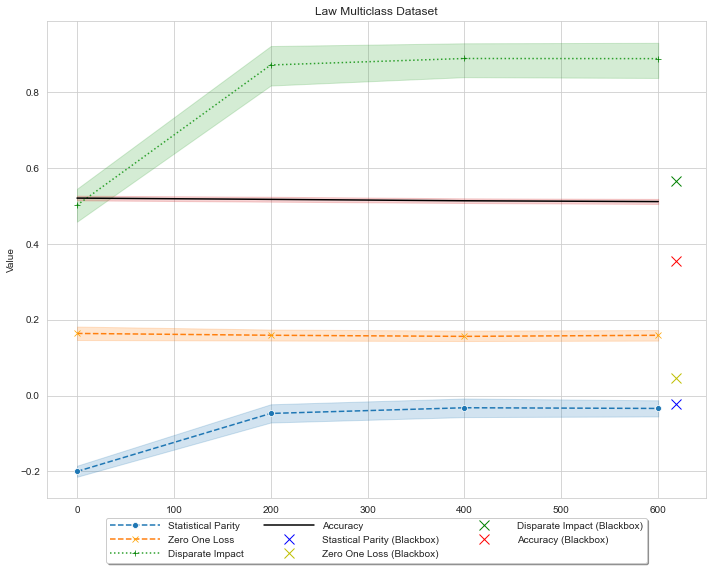

In [21]:
points = preparepoints(blackboxmetrics, demv.get_iters())

plot_metrics_curves(df, points, 'Law Multiclass Dataset')


In [19]:
unprivpergentage(data,protected_group, demv.get_iters())

Dataset size: 20427
Unprivileged group size: 1720
Percentage of unprivileged group: 8.42022812943653
Number of iterations: 618


In [20]:
blackboxmetrics

{'stat_par': -0.023063164391889115,
 'disp_imp': 0.5670680771195684,
 'zero_one_loss': 0.04680916918303185,
 'acc': 0.35544622313604546}